In [28]:
import pandas as pd
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as plt
import pandas_ta as pta

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
train = pd.read_csv('testing_data_complete.csv')

In [31]:
capital = 1000000

# Technical Indicators as Benchmarks

We choose the three most common technical indicators as trading signals: Bollinger bands, RSI and MACD as representatives of Momentum trading etc.

We iterate over all symbols used in our model, which are the largest and most famous stocks from the S&P500/NASDAQ.
We sum over all cumulative returns per symbol and average the returns, to then compare it with the other two technical indicators and the S&P500 itself as an conservative Buy and Hold Strategy.

### ToDo:  Add loss factor for transaction costs and rescale for amount of initial capital. 
(meaning: the strategies only show percentual increase of assets if implemented. Thus we need to multiply or rescale in order to account for initial funds)

In [32]:
arr = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["sma"] = df["close"].rolling(window=20).mean()
    df["std"] = df["close"].rolling(window=20).std()
    df["upper_band"] = df["sma"] + (df["std"]*2)
    df["lower_band"] = df["sma"] - (df["std"]*2)

    df["Position"] = None
    df["Position"][20:] = np.where(df["close"][20:]<df["lower_band"][20:],1,0)
    df["Position"][20:] = np.where(df["close"][20:]>df["upper_band"][20:],-1,df["Position"][20:])
    df["Bollinger_Returns"] = 1 + (df["close"].pct_change()*df["Position"].shift(1))
    
    x = df["Bollinger_Returns"].cumprod().to_numpy()
    arr.append(x)
bollinger = np.mean(arr, axis=0)

In [33]:
arr = []
ch = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["ema12"] = df["close"].ewm(span=12).mean()
    df["ema26"] = df["close"].ewm(span=26).mean()
    df["macd"] = df["ema12"] - df["ema26"]
    df["macd_signal"] = df["macd"].ewm(span=9).mean()
    df["macd_histogram"] = df["macd"] - df["macd_signal"]

    df["regime"] = pd.NA
    for i in range(0, len(df)-1):
        if df["macd_histogram"][i]>= 0:
            df["regime"][i+1]=1
        else:
            df["regime"][i+1]=0

    df["change"] = df["close"].pct_change()+1
    df["MACD_returns"] = 1.0
    for i in range(1, len(df)):
        if df["regime"][i] == 1:
            df["MACD_returns"][i] = df["change"][i]
    
    x = df["MACD_returns"].cumprod().to_numpy()
    c = df["change"].cumprod().to_numpy()
    arr.append(x)
    ch.append(c)
macd = np.mean(arr, axis=0)
buyandhold = np.mean(ch, axis=0)

In [34]:
arr = []
for tic in train["tic"].unique():
    
    df = train.loc[train['tic'] == tic]
    
    
    df.reset_index(drop=True)
    df.set_index('date', inplace=True)
    

    df["rsi"] = pta.rsi(df["close"],2)
    df["rule"] = 0
    z = 1

    for i in range(0, len(df)-1):
        if df["rsi"][i]<= 10 and z ==1:
            df["rule"][i+1]=1
            z = 0
        elif df["rsi"][i]>= 60 and z == 0:
            df["rule"][i] = -1
            z = 1
    for i in range(1, len(df)):
        if df["rule"][i-1] == 1 and df["rule"][i]==0:
            df["rule"][i] = 1
    df["change"] = df["close"].pct_change()+1
    df["RSI_Returns"] = 1.0
    for i in range(0, len(df)):
        if df["rule"][i] != 0:
            df["RSI_Returns"][i] = df["change"][i]
    
    x = df["RSI_Returns"].cumprod().to_numpy()
    arr.append(x)
rsi = np.mean(arr, axis=0)

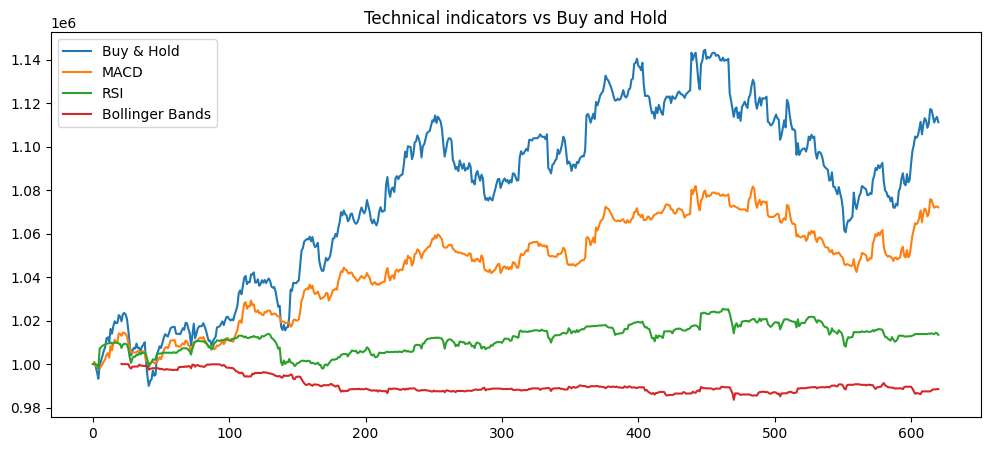

In [35]:
plt.figure(figsize=[12,5])
plt.plot(buyandhold*capital, label = "Buy & Hold")
plt.plot(macd*capital, label = "MACD")
plt.plot(rsi*capital, label = "RSI")
plt.plot(bollinger*capital, label = "Bollinger Bands")
plt.legend()
#plt.yscale("log")
plt.title("Technical indicators vs Buy and Hold")
plt.savefig("Technical Indicators.png")

# First trys

## Bollinger Bands
based on https://www.quantifiedstrategies.com/python-bollinger-band-trading-strategy/

In [ ]:
df = train.loc[train['tic'] == "AAPL"]
df.reset_index(drop=True)
df.set_index('date', inplace=True)
df["sma"] = df["close"].rolling(window=20).mean()
df["std"] = df["close"].rolling(window=20).std()
df["upper_band"] = df["sma"] + (df["std"]*2)
df["lower_band"] = df["sma"] - (df["std"]*2)
df["Position"] = None

df["Position"][20:] = np.where(df["close"][20:]<df["lower_band"][20:],1,0)
df["Position"][20:] = np.where(df["close"][20:]>df["upper_band"][20:],-1,df["Position"][20:])
df["Bollinger_Returns"] = 1 + (df["close"].pct_change()*df["Position"].shift(1))

## MACD
based on https://www.quantifiedstrategies.com/python-and-macd-trading-strategy/

In [ ]:
df["ema12"] = df["close"].ewm(span=12).mean()
df["ema26"] = df["close"].ewm(span=26).mean()
df["macd"] = df["ema12"] - df["ema26"]
df["macd_signal"] = df["macd"].ewm(span=9).mean()
df["macd_histogram"] = df["macd"] - df["macd_signal"]

df["regime"] = pd.NA
for i in range(0, len(df)-1):
    if df["macd_histogram"][i]>= 0:
        df["regime"][i+1]=1
    else:
        df["regime"][i+1]=0

df["change"] = df["close"].pct_change()+1
df["MACD_returns"] = 1.0
for i in range(1, len(df)):
    if df["regime"][i] == 1:
        df["MACD_returns"][i] = df["change"][i]

## RSI
based on https://www.quantifiedstrategies.com/python-and-rsi-trading-strategy/

In [ ]:
df["rsi"] = pta.rsi(df["close"],2)
df["rule"] = 0
z = 1

for i in range(0, len(df)-1):
    if df["rsi"][i]<= 10 and z ==1:
        df["rule"][i+1]=1
        z = 0
    elif df["rsi"][i]>= 60 and z == 0:
        df["rule"][i] = -1
        z = 1
for i in range(1, len(df)):
    if df["rule"][i-1] == 1 and df["rule"][i]==0:
        df["rule"][i] = 1
df["change"] = df["close"].pct_change()+1
df["RSI_Returns"] = 1.0
for i in range(0, len(df)):
    if df["rule"][i] != 0:
        df["RSI_Returns"][i] = df["change"][i]

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(df["MACD_returns"].cumprod(), label = "MACD")
plt.plot(df["change"].cumprod(), label = "Buy & Hold")
plt.plot(df["RSI_Returns"].cumprod(), label = "RSI")
plt.plot(df["Bollinger_Returns"].cumprod(), label = "Bollinger Bands")
plt.legend()
#plt.yscale("log")
plt.title("Technical indicators vs Buy and Hold")
plt.show()